# Tutorial 6: Mixed Precision Quantization Search with Mase and Optuna

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [23]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can load the Bert checkpoint directly from HuggingFace.

In [24]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

If you have previously ran the tutorial on Neural Architecture Search (NAS), run the following cell to import the best model obtained from the search process.

In [ ]:
from pathlib import Path
import dill

lab2_out_dir = Path("/workspace/labs/lab2/outputs")
lab3_out_dir = Path("/workspace/labs/lab3/outputs")

with open(f"{lab2_out_dir}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [26]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads.

In [27]:
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_categorical` function, which triggers the chosen sampler to choose a layer type. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [28]:
from chop.tools.utils import deepsetattr
from copy import deepcopy


def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                kwargs["config"] = {
                    "data_in_width": 8,
                    "data_in_frac_width": 4,
                    "weight_width": 8,
                    "weight_frac_width": 4,
                    "bias_width": 8,
                    "bias_frac_width": 4,
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [29]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [30]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [31]:
import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=1,
    timeout=60 * 60 * 24,
)

[I 2026-02-01 19:37:21,434] A new study created in memory with name: bert-tiny-nas-study
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.307600
1000,0.303500
1500,0.304300
2000,0.317700
2500,0.307800
3000,0.357500


[I 2026-02-01 19:39:54,034] Trial 0 finished with value: 0.87656 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.dense_type': <cla

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
[I 2026-02-02 10:26:32,795] A new study created in memory with name: tutorial6_mixed_precision_search
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  optuna_warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  optuna_warn(message)
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.309400
1000,0.316700
1500,0.313000
2000,0.325700
2500,0.308700
3000,0.362800


[I 2026-02-02 10:29:12,285] Trial 0 finished with value: 0.87464 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'ber

Step,Training Loss
500,0.303300
1000,0.294700
1500,0.301300
2000,0.324500
2500,0.302800
3000,0.364100


[I 2026-02-02 10:32:07,774] Trial 1 finished with value: 0.87484 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.Linea

Step,Training Loss
500,0.304500
1000,0.309800
1500,0.302200
2000,0.322900
2500,0.307700
3000,0.360900


[I 2026-02-02 10:34:37,748] Trial 2 finished with value: 0.8762 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'torch.nn.modu

Step,Training Loss
500,0.303500
1000,0.297400
1500,0.308900
2000,0.322400
2500,0.303100
3000,0.355100


[I 2026-02-02 10:37:28,285] Trial 3 finished with value: 0.87484 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.intermediate.dense_type': <cla

Step,Training Loss
500,0.302700
1000,0.305800
1500,0.310800
2000,0.321900
2500,0.309600
3000,0.366300


[I 2026-02-02 10:40:02,088] Trial 4 finished with value: 0.87388 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.d

Step,Training Loss
500,0.304000
1000,0.313500
1500,0.305200
2000,0.314300
2500,0.305900
3000,0.362200


[I 2026-02-02 10:42:37,419] Trial 5 finished with value: 0.8756 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1

Step,Training Loss
500,0.306500
1000,0.300500
1500,0.300800
2000,0.320100
2500,0.305000
3000,0.359600


[I 2026-02-02 10:45:22,603] Trial 6 finished with value: 0.8766 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1

Step,Training Loss
500,0.309800
1000,0.301800
1500,0.306900
2000,0.324700
2500,0.306600
3000,0.363200


[I 2026-02-02 10:47:54,772] Trial 7 finished with value: 0.87388 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'chop.nn.quan

Step,Training Loss
500,0.307000
1000,0.312000
1500,0.310300
2000,0.315700
2500,0.307600
3000,0.367600


[I 2026-02-02 10:50:32,116] Trial 8 finished with value: 0.87608 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'ber

Step,Training Loss
500,0.309200
1000,0.300000
1500,0.300900
2000,0.316000
2500,0.303700
3000,0.358700


[I 2026-02-02 10:53:19,074] Trial 9 finished with value: 0.87368 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.

Step,Training Loss
500,0.306200
1000,0.304400
1500,0.305800
2000,0.320700
2500,0.306600
3000,0.364400


[I 2026-02-02 10:56:12,215] Trial 10 finished with value: 0.8742 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.d

Step,Training Loss
500,0.308700
1000,0.305700
1500,0.307100
2000,0.322400
2500,0.311700
3000,0.366600


[I 2026-02-02 10:58:51,832] Trial 11 finished with value: 0.87564 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.dense_type': <cl

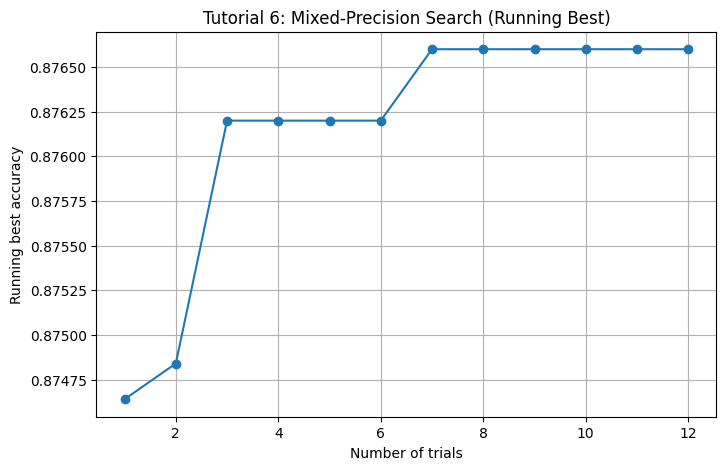

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  optuna_warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  optuna_warn(message)


Tutorial 6 search done.
Best accuracy (study.best_value): 0.8766
Plot saved to: /workspace/labs/lab2/outputs/tutorial6_running_best.png


/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


Best model (as searched) eval_accuracy: 0.8246


INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


Compressed (no post-train) eval_accuracy: 0.5020


INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

/workspace/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.338300
1000,0.287900
1500,0.283800
2000,0.288200
2500,0.272500
3000,0.317700


Compressed (+ post-train 1 epoch) eval_accuracy: 0.8630
Saved JSON-safe best params + results to: /workspace/labs/lab2/outputs/tutorial6_best_results.json


In [ ]:
import gc
import json
from copy import deepcopy
from pathlib import Path

import optuna
import matplotlib.pyplot as plt
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification

from chop.tools import get_tokenized_dataset, get_trainer
from chop.tools.utils import deepsetattr
import chop.passes as passes
from chop import MaseGraph
from chop.pipelines import CompressionPipeline
from chop.nn.quantized.modules.linear import LinearInteger

# -------------------------
# Config
# -------------------------
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

lab2_out_dir = Path("/workspace/labs/lab2/outputs")
lab2_out_dir.mkdir(parents=True, exist_ok=True)

# Search budget
n_trials = 12
search_epochs = 1

# Compression settings
pruning_sparsity = 0.5
post_compress_epochs = 1

HF_INPUT_NAMES = ["input_ids", "attention_mask", "labels"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# -------------------------
# Helpers
# -------------------------
def cleanup(*objs):
    for o in objs:
        try:
            del o
        except Exception:
            pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def running_best(study: optuna.Study):
    best = float("-inf")
    xs, ys = [], []
    for t in sorted(study.trials, key=lambda x: x.number):
        if t.value is None:
            continue
        best = max(best, float(t.value))
        xs.append(len(xs) + 1)
        ys.append(best)
    return xs, ys

def json_safe(obj):
    """Convert Optuna params that may include Python types/classes into JSON-serializable forms."""
    if isinstance(obj, type):
        return f"{obj.__module__}.{obj.__qualname__}"
    if isinstance(obj, dict):
        return {k: json_safe(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [json_safe(v) for v in obj]
    return obj

# -------------------------
# Load dataset
# -------------------------
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# -------------------------
# Load base model
#   - Prefer tutorial_5_best_model.pkl if it exists
#   - Otherwise, fall back to HF bert-tiny seq-cls
# -------------------------
base_model_path = lab2_out_dir / "tutorial_5_best_model.pkl"

if base_model_path.exists():
    import dill
    with open(base_model_path, "rb") as f:
        base_model = dill.load(f)
else:
    base_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Ensure classification-friendly config
try:
    base_model.config.problem_type = "single_label_classification"
except Exception:
    pass

# -------------------------
# 1) Search space (Tutorial 6 minimal & robust)
#   Mixed precision = per-layer choice: FP Linear vs INT8 LinearInteger
# -------------------------
search_space = {
    "linear_layer_choices": [nn.Linear, LinearInteger],
}

# Fixed config for LinearInteger (THIS FIXES "config is None!")
INT8_CONFIG = {
    "data_in_width": 8,
    "data_in_frac_width": 4,
    "weight_width": 8,
    "weight_frac_width": 4,
    "bias_width": 8,
    "bias_frac_width": 4,
}

# -------------------------
# 2) Model constructor
# -------------------------
def construct_model(trial: optuna.Trial):
    trial_model = deepcopy(base_model)

    # Swap every Linear layer according to trial choice
    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )
            if new_layer_cls is nn.Linear:
                continue

            # Build replacement layer (LinearInteger needs `config=...`)
            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }
            if new_layer_cls is LinearInteger:
                kwargs["config"] = INT8_CONFIG

            new_layer = new_layer_cls(**kwargs)

            # Copy weights/bias when shapes are compatible
            with torch.no_grad():
                if hasattr(new_layer, "weight") and hasattr(layer, "weight"):
                    if new_layer.weight.shape == layer.weight.shape:
                        new_layer.weight.copy_(layer.weight)
                if layer.bias is not None and hasattr(new_layer, "bias") and new_layer.bias is not None:
                    if new_layer.bias.shape == layer.bias.shape:
                        new_layer.bias.copy_(layer.bias)

            deepsetattr(trial_model, name, new_layer)

    # Ensure config flag for trainer
    try:
        trial_model.config.problem_type = "single_label_classification"
    except Exception:
        pass

    return trial_model

# -------------------------
# 3) Objective
# -------------------------
def objective(trial: optuna.Trial):
    trainer = None
    model = None
    try:
        model = construct_model(trial).to(device)

        trainer = get_trainer(
            model=model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=search_epochs,
        )
        trainer.train()
        eval_results = trainer.evaluate()
        return float(eval_results["eval_accuracy"])
    finally:
        cleanup(trainer, model)

# -------------------------
# 4) Launch search
#   - GridSampler is NOT suitable here because params are dynamic per-layer.
#   - Use TPE or Random.
# -------------------------
sampler = optuna.samplers.TPESampler(seed=0)
study = optuna.create_study(
    direction="maximize",
    study_name="tutorial6_mixed_precision_search",
    sampler=sampler,
)
study.optimize(objective, n_trials=n_trials)

# Plot running best
x, y = running_best(study)
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker="o")
plt.xlabel("Number of trials")
plt.ylabel("Running best accuracy")
plt.title("Tutorial 6: Mixed-Precision Search (Running Best)")
plt.grid(True)
running_best_path = lab3_out_dir / "tutorial6_running_best.png"
plt.savefig(running_best_path)
plt.show()

print("Tutorial 6 search done.")
print("Best accuracy (study.best_value):", float(study.best_value))
print("Plot saved to:", running_best_path)

# -------------------------
# Build best model from best params
# -------------------------
fixed_trial = optuna.trial.FixedTrial(study.best_params)
best_model = construct_model(fixed_trial)

# Quick eval of best model as-is
trainer_best = None
try:
    trainer_best = get_trainer(
        model=best_model.to(device),
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=0,
    )
    best_eval = trainer_best.evaluate()
    best_eval_acc = float(best_eval["eval_accuracy"])
    print("Best model (as searched) eval_accuracy:", best_eval_acc)
finally:
    cleanup(trainer_best)

# -------------------------
# Import into Mase + CompressionPipeline (quantize + prune)
#   We do two variants:
#     A) compress, evaluate immediately
#     B) compress, post-train, evaluate
# -------------------------
BASE_QUANTIZATION_CONFIG = {
    "by": "type",
    "default": {"config": {"name": None}},
    "linear": {  # quantize remaining nn.Linear to integer
        "config": {
            "name": "integer",
            "data_in_width": 8,
            "data_in_frac_width": 4,
            "weight_width": 8,
            "weight_frac_width": 4,
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

BASE_PRUNING_CONFIG = {
    "weight": {"sparsity": pruning_sparsity, "method": "l1-norm", "scope": "local"},
    "activation": {"sparsity": pruning_sparsity, "method": "l1-norm", "scope": "local"},
}

def compress_with_mase(model_cpu: nn.Module):
    """
    IMPORTANT:
      - CompressionPipeline / passes mutate the dicts you pass in (e.g. pop("by")).
      - So we must pass FRESH COPIES every call.
    """
    mg = MaseGraph(model_cpu, hf_input_names=HF_INPUT_NAMES)
    mg, _ = passes.init_metadata_analysis_pass(mg)
    mg, _ = passes.add_common_metadata_analysis_pass(mg)

    qcfg = deepcopy(BASE_QUANTIZATION_CONFIG)
    pcfg = deepcopy(BASE_PRUNING_CONFIG)

    pipe = CompressionPipeline()
    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": qcfg,
            "prune_transform_pass": pcfg,
        },
    )
    return mg

# A) compress, no post-train
mg_a = None
trainer_a = None
try:
    # use deepcopy(best_model) so A/B are independent
    mg_a = compress_with_mase(deepcopy(best_model).to("cpu"))
    model_a = mg_a.model.to(device)

    trainer_a = get_trainer(
        model=model_a,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=0,
    )
    eval_a = trainer_a.evaluate()
    acc_a = float(eval_a["eval_accuracy"])
    print(f"Compressed (no post-train) eval_accuracy: {acc_a:.4f}")
finally:
    cleanup(trainer_a, mg_a)

# B) compress, with post-train
mg_b = None
trainer_b = None
try:
    mg_b = compress_with_mase(deepcopy(best_model).to("cpu"))
    model_b = mg_b.model.to(device)

    trainer_b = get_trainer(
        model=model_b,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=post_compress_epochs,
    )
    trainer_b.train()
    eval_b = trainer_b.evaluate()
    acc_b = float(eval_b["eval_accuracy"])
    print(f"Compressed (+ post-train {post_compress_epochs} epoch) eval_accuracy: {acc_b:.4f}")
finally:
    cleanup(trainer_b, mg_b)


best_results_path = lab3_out_dir / "tutorial6_best_results.json"
with best_results_path.open("w") as f:
    json.dump(
        {
            "search": {
                "best_value": float(study.best_value),
                "best_params": json_safe(study.best_params),
                "best_model_eval_accuracy": best_eval_acc,
                "n_trials": len(study.trials),
                "search_epochs": search_epochs,
                "sampler": sampler.__class__.__name__,
            },
            "compression": {
                "pruning_sparsity": pruning_sparsity,
                "post_compress_epochs": post_compress_epochs,
                "compressed_no_post_train_eval_accuracy": acc_a,
                "compressed_with_post_train_eval_accuracy": acc_b,
            },
            "artifacts": {
                "running_best_plot": str(running_best_path),
                "results_json": str(best_results_path),
            },
        },
        f,
        indent=2,
    )

print("Saved JSON-safe best params + results to:", best_results_path)
